In [516]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [517]:
engage = pd.read_csv('takehome_user_engagement.csv', encoding = 'utf-8')
user = pd.read_csv('takehome_users.csv', encoding = 'ANSI')

In [518]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [519]:
engage.shape

(207917, 3)

In [520]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### Creating the target variable

In [521]:
print('No. of Engage Users:', engage.user_id.nunique())
print('Total No. of Users:',user.object_id.nunique())

No. of Engage Users: 8823
Total No. of Users: 12000


Engage users are less than total no. of users. So first we will create our target variable 'adopted_user' using engagement data and then join that variable to our user list.

In [522]:
# Converting column to date time
engage.time_stamp = pd.to_datetime(engage['time_stamp'], infer_datetime_format = True)

# Creating Time Index
engage = engage.set_index(['time_stamp'])

# Define function to label users as adopted based on definition from the challange description
def label_adopted(x):
    
    # Selecting only rows of that users only
    df_temp = engage.loc[engage.user_id == x]
    
    adopted = 0
    for i in range(len(df_temp)-2):
        # Checking if a user has logged in at least 3 times in a 7 day week period
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    
    return adopted


# applying the function to users table
user['adopted_users'] = user.object_id.apply(label_adopted)

user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [523]:
user.adopted_users.value_counts()

0    10344
1     1656
Name: adopted_users, dtype: int64

### Missing Values

In [524]:
user.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_users                    0
dtype: int64

It looks like last session creation time for 3177 users are missing. There is no clarity on this from the challenge description. So it was decided to remove those users. 

In [525]:
user[user.last_session_creation_time.isnull()]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,0
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaN,0,0,130,9270.0,0
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,175,NaN,0
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,211,NaN,0
17,18,2013-08-24 00:26:46,Gregersen Celina,CelinaAGregersen@jourrapide.com,GUEST_INVITE,NaN,0,0,2,3153.0,0
25,26,2013-07-28 00:53:32,Wexler Florian,FlorianWexler@jourrapide.com,ORG_INVITE,NaN,0,0,56,11857.0,0
31,32,2013-04-17 16:21:30,Perez Timothy,TimothyJPerez@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,98,NaN,0
33,34,2014-02-03 20:55:18,Holm Sara,SaraMHolm@hotmail.com,ORG_INVITE,NaN,0,0,33,3721.0,0
34,35,2013-08-01 10:55:26,Krueger Dieter,DieterKrueger@gustr.com,PERSONAL_PROJECTS,NaN,0,0,59,NaN,0


In [526]:
# Dropping users whose last session creation time is missing
user = user.dropna(subset = ['last_session_creation_time'])

In [527]:
# Fill missing invited by users id as 0
user.invited_by_user_id = user.invited_by_user_id.fillna(0)

In [528]:
user.isnull().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adopted_users                 0
dtype: int64

### Data Transformation and Feature Creation
Last session created time need to be converted to data time format and email name to be extracted from email id. 

In [529]:
user.last_session_creation_time = user.last_session_creation_time.apply(lambda x: datetime.fromtimestamp(x))
user.creation_time = pd.to_datetime(user.creation_time)
#user.last_session_creation_time.apply(lambda x: datetime.strftime(int(x),))

In [530]:
# Creating duration Field as difference between creation time and last session time
user['duration'] = (user.last_session_creation_time - user.creation_time)/np.timedelta64(1, 'D')

# Dropping creation time and last creation time
user.drop(['creation_time', 'last_session_creation_time'], axis = 1 , inplace = True)

In [531]:
user['email'] = user.email.str.split('@', expand = True)[1]
user.email.value_counts()

gmail.com         2930
yahoo.com         1726
jourrapide.com     883
gustr.com          842
cuvox.de           828
hotmail.com        803
xvnbr.com            2
mumdc.com            2
luque.com            2
xybhi.com            2
oqpze.com            2
tpswd.com            1
xpgje.com            1
apagc.com            1
oyewb.com            1
jfvoj.com            1
ceqro.com            1
dzpyd.com            1
xsuwb.com            1
uwbpx.com            1
octon.com            1
xgmsd.com            1
tawht.com            1
bbdkr.com            1
tfsce.com            1
cuvvr.com            1
jlcfq.com            1
wqmog.com            1
vqpgh.com            1
dihjz.com            1
                  ... 
xhtxh.com            1
yyyxt.com            1
tlxhq.com            1
fboqn.com            1
wujjs.com            1
jvcvb.com            1
ekkwg.com            1
ktqxt.com            1
vlups.com            1
hugtc.com            1
igfhw.com            1
jrggl.com            1
dshis.com  

Grouping bad email ids as others

In [532]:
# Filtering top 6 email categories
top_emails = user.email.value_counts()[:6]

# Combining other email categories as "others"
user.email = [x if x in top_emails else 'others' for x in user.email]

# Displaying the new email cateogories
user.email.value_counts()

gmail.com         2930
yahoo.com         1726
jourrapide.com     883
gustr.com          842
cuvox.de           828
others             811
hotmail.com        803
Name: email, dtype: int64

In [533]:
# Dropping name and user_id column as it is not useful to us
user.drop(['name', 'object_id'], axis = 1, inplace = True)

In [534]:
user.head()

,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users,duration
0,yahoo.com,GUEST_INVITE,1,0,11,10803.0,0,0.229167
1,gustr.com,ORG_INVITE,0,0,1,316.0,1,136.229167
2,gustr.com,ORG_INVITE,0,0,94,1525.0,0,0.229167
3,yahoo.com,GUEST_INVITE,0,0,1,5151.0,0,1.229167
4,yahoo.com,GUEST_INVITE,0,0,193,5240.0,0,5.229167


### EDA

In [535]:
user.org_id.value_counts()

0      228
1      172
2      150
3      125
4      122
6      102
9       91
7       88
5       87
10      68
8       67
14      66
17      58
12      57
11      56
18      54
20      50
13      50
33      47
15      47
22      46
25      44
31      44
24      44
16      44
23      43
27      43
28      42
21      41
34      40
      ... 
273      9
361      9
359      9
310      9
358      9
383      9
364      9
336      9
352      9
381      9
323      8
294      8
315      8
365      8
183      8
304      8
378      8
344      8
355      7
329      7
232      7
395      7
412      7
353      6
396      6
322      6
400      6
397      5
386      4
416      2
Name: org_id, Length: 417, dtype: int64

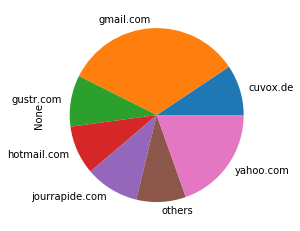

In [536]:
user.groupby('email').size().plot(kind = 'pie')

In [537]:
def plot_dist_target(data,col, group, labels = False):
    # Grouping required feature and target column
    table = data.groupby([col,group]).size().unstack()

    #Normalizing i.e Calculating %target
    table = (table.divide(table.sum(axis=1), axis=0))*100

    #Renaming the column index from category to string and sorting based on %
    table = table.rename(columns=str).reset_index()
    table.sort_values('1',ascending = False, inplace = True)
    table = table.reset_index(drop = 'True')

    #Setting Figure size and plotting the bar chart
    fig_dims = (7, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    
    g = sns.barplot(data = table, x = col,y='1', ax = ax, order = table[col])
    
    if labels == True:
        for index, row in table.iterrows():
            g.text(row.name,row['1'], round(row['1'],1), color='black', ha="center")

    
    plt.ylabel('Target %')
    plt.xticks(rotation = 90)
    plt.title(col)
    plt.tight_layout()
    plt.show()

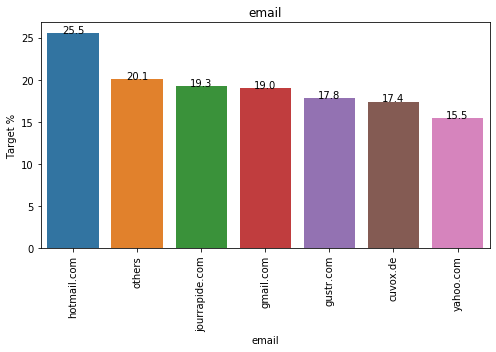

In [538]:
plot_dist_target(user, 'email','adopted_users', labels = True)

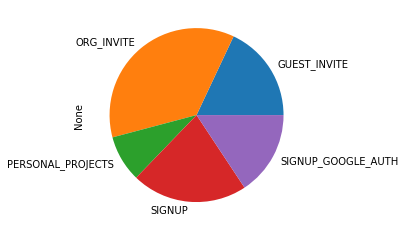

In [539]:
user.groupby('creation_source').size().plot(kind = 'pie')

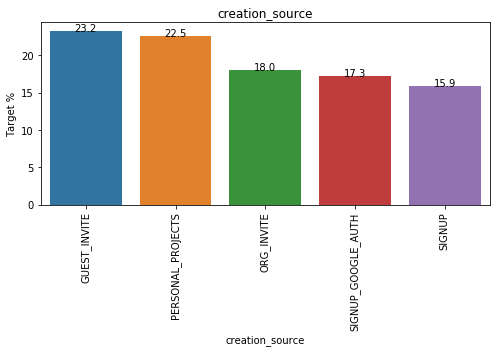

In [540]:
plot_dist_target(user, 'creation_source', 'adopted_users',labels = True)

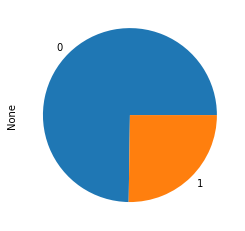

In [541]:
user.groupby('opted_in_to_mailing_list').size().plot(kind = 'pie')

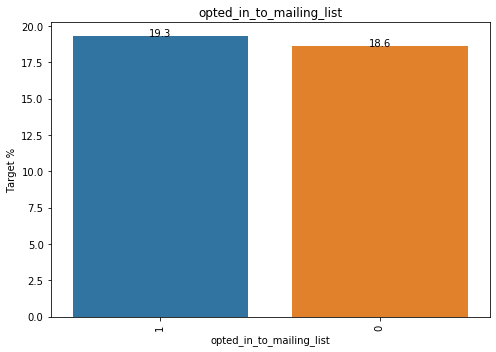

In [542]:
plot_dist_target(user, 'opted_in_to_mailing_list','adopted_users', labels = True)

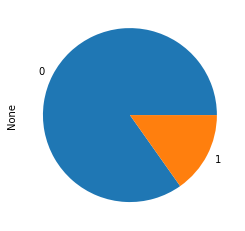

In [543]:
#enabled_for_marketing_drip

user.groupby('enabled_for_marketing_drip').size().plot(kind = 'pie')

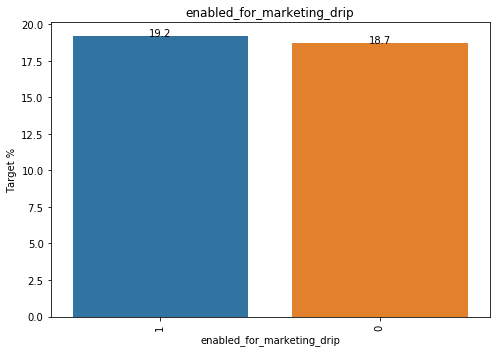

In [544]:
plot_dist_target(user, 'enabled_for_marketing_drip', 'adopted_users', labels = True)

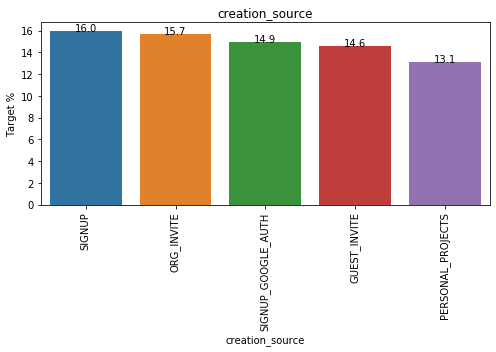

In [545]:
plot_dist_target(user, 'creation_source', 'enabled_for_marketing_drip',labels = True)

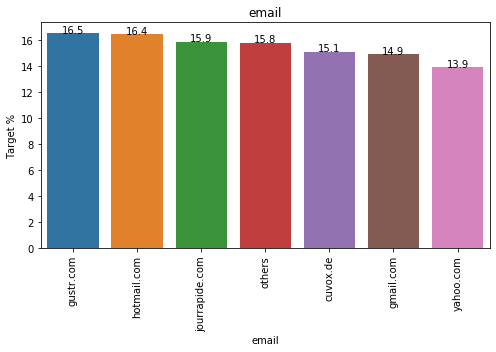

In [546]:
plot_dist_target(user, 'email', 'enabled_for_marketing_drip',labels = True)

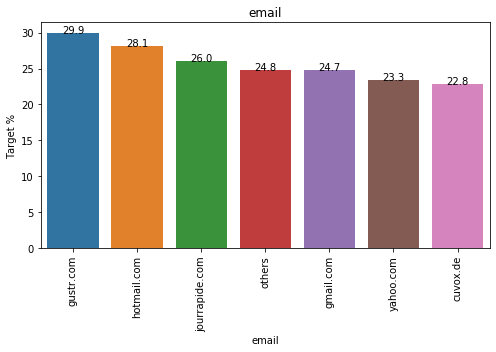

In [562]:
plot_dist_target(user, 'email', 'opted_in_to_mailing_list',labels = True)

Label Encoding org_id and invited_by_user_id

In [548]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
org_labels = gle.fit_transform(user['org_id'])
user.org_id = org_labels

invited_labels = gle.fit_transform(user['invited_by_user_id'])
user.invited_by_user_id = invited_labels

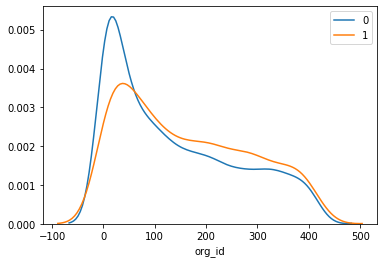

In [549]:
condition = (user.adopted_users == 0)
_ = sns.distplot(user[condition].org_id, label = 0, hist = False)#, alpha = 0.5)
_ = sns.distplot(user[~condition].org_id, label = 1, hist = False)#, alpha = 0.5)

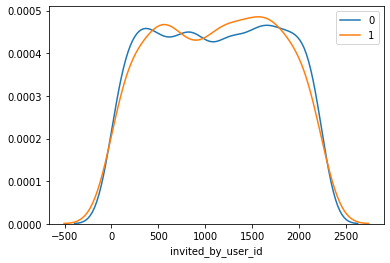

In [556]:
condition2 = user.invited_by_user_id > 0
_ = sns.distplot(user[condition & condition2].invited_by_user_id, label = 0, hist = False)#, alpha = 0.5)
_ = sns.distplot(user[~condition & condition2].invited_by_user_id, label = 1, hist = False)#, alpha = 0.5)

In [558]:
user[~condition2].adopted_users.value_counts(normalize = True)

0    0.82382
1    0.17618
Name: adopted_users, dtype: float64

In [559]:
user[condition2].adopted_users.value_counts(normalize = True)

0    0.802554
1    0.197446
Name: adopted_users, dtype: float64

In [567]:
user.enabled_for_marketing_drip.value_counts(normalize= True)

0    0.848011
1    0.151989
Name: enabled_for_marketing_drip, dtype: float64

- Hotmail has higher adopted users compared to other email providers. But hotmail customers are just 9% of all the customers
- Guest Invite and personal projects are important reasons for more adopted users. This may be as the intent is more on usage
- ~25% of the users opt for mailing list and most of them are from gmail
- ~15% of the users are enabled for marketing drip campaigns
- Marketing campaign are only effective for gust and hotmail providers
- Org_id distribution suggests that, broadly there are 3 kinds of org. Label 1 to 100, 100 to 400 and >400. 
- Ther are specific users whose reference give more adopted users than others. This can be called as influencers. 

### Modelling
#### We have more categorical variables. It would be better if we go with tree based methods. We will use random forest here

In [574]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 8 columns):
email                         8823 non-null object
creation_source               8823 non-null object
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null int64
adopted_users                 8823 non-null int64
duration                      8823 non-null float64
dtypes: float64(1), int64(5), object(2)
memory usage: 620.4+ KB


Encoding Categorical Variables

In [575]:
# One-hot-encode all categorical features
df_encoded = pd.get_dummies(user, columns = ['email', 'creation_source'], drop_first = True)

df_encoded.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users,duration,email_gmail.com,email_gustr.com,email_hotmail.com,email_jourrapide.com,email_others,email_yahoo.com,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,2024,0,0.229167,0,0,0,0,0,1,0,0,0,0
1,0,0,1,48,1,136.229167,0,1,0,0,0,0,1,0,0,0
2,0,0,94,264,0,0.229167,0,1,0,0,0,0,1,0,0,0
3,0,0,1,967,0,1.229167,0,0,0,0,0,1,0,0,0,0
4,0,0,193,984,0,5.229167,0,0,0,0,0,1,0,0,0,0


In [616]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(['adopted_users'], axis = 1)
y = df_encoded.adopted_users

#Splitting Data into Training and Test Data Set
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [617]:
# data normalization with sklearn
from sklearn.preprocessing import PowerTransformer

# Copy of Data set
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

numeric = ['duration']
for i in numeric:
    
    # fit on training data column
    scale = PowerTransformer().fit(X_train_norm[[i]])
    
    # transform the training data column
    X_train_norm[i] = scale.transform(X_train_norm[[i]])
    
    # transform the testing data column
    X_test_norm[i] = scale.transform(X_test_norm[[i]])

In [618]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

for i in numeric:
    
    # fit on training data column
    scale = MinMaxScaler().fit(X_train_norm[[i]])
    
    # transform the training data column
    X_train_norm[i] = scale.transform(X_train_norm[[i]])
    
    # transform the testing data column
    X_test_norm[i] = scale.transform(X_test_norm[[i]])

In [619]:
# Base Line Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support,log_loss
class_names = ['Not Adopted', 'Adopted']

In [620]:
def auc_curve(y_test,y_pred_test,auc_test):
    fpr,tpr, threshold = roc_curve(y_test, y_pred_test)
    _ = plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' %auc_test )
    _ = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = plt.xlim([0.0, 1.0])
    _ = plt.ylim([0.0, 1.05])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic example')
    _ = plt.legend(loc="lower right")

Training accuracy: 0.9702
Test accuracy    : 0.9581
Training AUC Score: 0.9980
Testing AUC Score: 0.9888
Classification Report - Training
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5750
           1       0.87      0.98      0.92      1308

    accuracy                           0.97      7058
   macro avg       0.93      0.98      0.95      7058
weighted avg       0.97      0.97      0.97      7058

Classification Report - Testing
              precision    recall  f1-score   support

 Not Adopted       0.99      0.96      0.97      1417
     Adopted       0.86      0.94      0.90       348

    accuracy                           0.96      1765
   macro avg       0.92      0.95      0.94      1765
weighted avg       0.96      0.96      0.96      1765



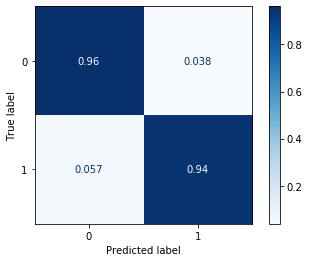

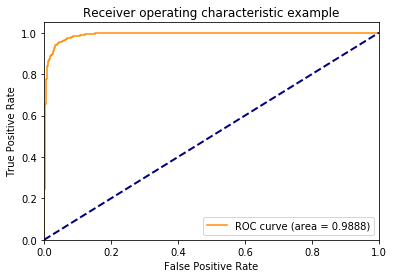

In [625]:
# Base Line Evaluation
rf = RandomForestClassifier(max_depth = 10, random_state = 42, n_jobs = 4, class_weight = 'balanced')

rf.fit(X_train_norm,y_train)

#Predicting for testing and trainig data sets
y_test_proba = rf.predict_proba(X_test_norm)[:,1]
y_train_proba = rf.predict_proba(X_train_norm)[:,1]

y_pred_test = rf.predict(X_test_norm)
y_pred_train = rf.predict(X_train_norm)

#Accuracy Score
print("Training accuracy: %0.4f" %rf.score(X_train_norm, y_train))
print("Test accuracy    : %0.4f" %rf.score(X_test_norm, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(rf, X_test_norm, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


Top 20 Feature Importance


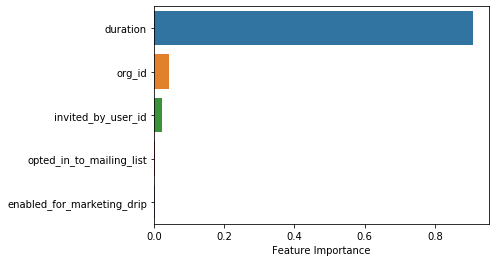

In [626]:
import seaborn as sns
coefficients = rf.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 20 Feature Importance")
_ = sns.barplot(data = coef[:5], x = 'Feature Importance', y = coef[:5].index, orient = 'h')
#_ = plt.barh(coef[:20].index, coef['Feature Importance'][:20])

In [627]:
user.groupby('adopted_users')['duration'].mean()

adopted_users
0      5.548547
1    292.737017
Name: duration, dtype: float64

Duration of usage is the largest important feature for predicting the adopted users.
Next in line is org_id and invited_user_id. This says that reference and organization to which user belongs to have a significant influence on adoption users.